# Optimizing data reductions with NDArrays

Blosc2 leverages the power of NumPy to perform operations efficiently (with minimla memory footprint and execution time) on compressed multidimensional arrays. By compressing data with Blosc2, it is possible to reduce the memory and storage space required to store large datasets, while maintaining fast access times. This is especially beneficial for systems with memory constraints, as it allows for faster data access and manipulation.

In this tutorial, we will explore how Python-Blosc2 can efficiently perform a special class of particularly costly computations called *data reductions* (e.g. ``sum``, ``mean``), which are especially common in data science, by leveraging the benefits of the compression-first NDArray object. We'll also dive into further tuning the performance of these operations by using different chunk shapes, compression levels and codecs.  Finally, we will compare the performance of Python-Blosc2 with NumPy.

**Note**: This tutorial assumes that you have Python, NumPy, matplotlib and Blosc2 installed on your system.  Also, this notebook has been run on a CPU (Intel 13900K) with a relatively large L3 cache (36 MB). As it turns out, performance in Blosc2 is very sensitive to the CPU cache size, and the results may vary on different CPUs.

## Creating a test array

First, let's create a 3D array of type float64 with axes (X, Y, Z), each of length 1000. We will perform reductions along the X, Y, and Z axes, comparing Python-Blosc2 performance (with and without compression) against NumPy.

In [1]:
from time import time

import matplotlib.pyplot as plt
import numpy as np

import blosc2

In [2]:
# Create a 3D array of type float64 (8 GB)
dtype = np.float64
shape = (1000, 1000, 1000)
size = np.prod(shape)
a = np.linspace(0, 1000, num=size, dtype=dtype).reshape(shape)

### 1) Reductions with NumPy

We will start by performing different sum reductions using NumPy - summing along the X, Y, and Z axes (and getting 2D arrays as result) and then summing along all axes (and getting a scalar as result). This will provide a baseline for comparison with Blosc2.

In [3]:
axes = ("X", "Y", "Z", "all")
meas_np = {"sum": {}, "time": {}}
for n, axis in enumerate(axes):
    n = n if axis != "all" else None
    t0 = time()
    meas_np["sum"][axis] = np.sum(a, axis=n)
    t = time() - t0
    meas_np["time"][axis] = time() - t0

### 2) Reductions with Blosc2
In order to test reductions in Blosc2, we will need to convert the array to the Blosc2-compatible `NDArray` type. NDArray arrays are compressed, and we can choose how this compression is done during conversion by defining compression parameters: number of threads, compression levels, codecs, and chunk sizes. We will do a grid search over different combinations of these parameters to see how it affects performance. To do this, let's write a function that runs through the different compression combinations and performs the reductions over the different axes, for a fixed chunk shape (later on we'll vary the chunk shape too).

In [4]:
# Grid search params for Blosc2
clevels = (0, 5)
codecs = (blosc2.Codec.LZ4, blosc2.Codec.ZSTD)


# Create a 3D array of type float64
def measure_blosc2(chunks, blocks=None):
    meas = {}
    for codec in codecs:
        meas[codec] = {}
        for clevel in clevels:
            meas[codec][clevel] = {"sum": {}, "time": {}}
            cparams = blosc2.CParams(clevel=clevel, codec=codec)
            a1 = blosc2.asarray(a, chunks=chunks, blocks=blocks, cparams=cparams)
            print(f"chunks: {a1.chunks}, blocks: {a1.blocks}")
            if clevel > 0:
                print(f"cratio for {codec.name} + SHUFFLE: {a1.schunk.cratio:.1f}x")
            # Iterate on Blosc2 and NumPy arrays
            for n, axis in enumerate(axes):
                n = n if axis != "all" else None
                t0 = time()
                meas[codec][clevel]["sum"][axis] = a1.sum(axis=n)
                t = time() - t0
                meas[codec][clevel]["time"][axis] = t
                # If interested, you can uncomment the following line to check the results
                # np.testing.assert_allclose(meas[codec][clevel]["sum"][axis],
                #                           meas_np["sum"][axis])
    return meas

Now comes a helper function to plot and helpfully summarise the results of the measurements. It will plot the time taken for each reduction operation along different axes, comparing NumPy with Blosc2 for the different compression levels and codecs.

In [5]:
def plot_meas(meas_np, meas, chunks):
    _fig, ax = plt.subplots()

    # Define the groups and bar width
    groups = meas_np["time"].keys()
    bar_width = 0.2
    indices = np.arange(len(groups))

    # Plot NumPy times
    ax.bar(indices - 1.5 * bar_width, [meas_np["time"][g] for g in groups], bar_width, label="NumPy")

    # Plot Blosc2 times
    ax.bar(
        indices - 0.5 * bar_width,
        [meas[blosc2.Codec.LZ4][0]["time"][g] for g in groups],
        bar_width,
        label="Blosc2, no compression",
    )
    ax.bar(
        indices + 0.5 * bar_width,
        [meas[blosc2.Codec.LZ4][5]["time"][g] for g in groups],
        bar_width,
        label="Blosc2, LZ4 + SHUFFLE",
    )
    ax.bar(
        indices + 1.5 * bar_width,
        [meas[blosc2.Codec.ZSTD][5]["time"][g] for g in groups],
        bar_width,
        label="Blosc2, ZSTD + SHUFFLE",
    )

    # Set the labels and title
    ax.set_xlabel("Axis")
    ax.set_ylabel("Time (s)")
    ax.set_title("Reduction Times")
    ax.set_xticks(indices)
    ax.set_xticklabels(groups)
    ax.legend()

    plt.tight_layout()
    plt.show()

#### Results for Blosc2
Now that we have the experiments set up, let's run the grid search with a fixed chunk shape, and plot the results compared to NumPy. We will start with the default chunk shape, which is set to `None` in Blosc2, meaning that it will be automatically selected based on the CPU cache size.

chunks: (1, 1000, 1000), blocks: (1, 20, 1000)
chunks: (1, 1000, 1000), blocks: (1, 50, 1000)
cratio for LZ4 + SHUFFLE: 16.7x
chunks: (1, 1000, 1000), blocks: (1, 20, 1000)
chunks: (1, 1000, 1000), blocks: (1, 50, 1000)
cratio for ZSTD + SHUFFLE: 63.6x


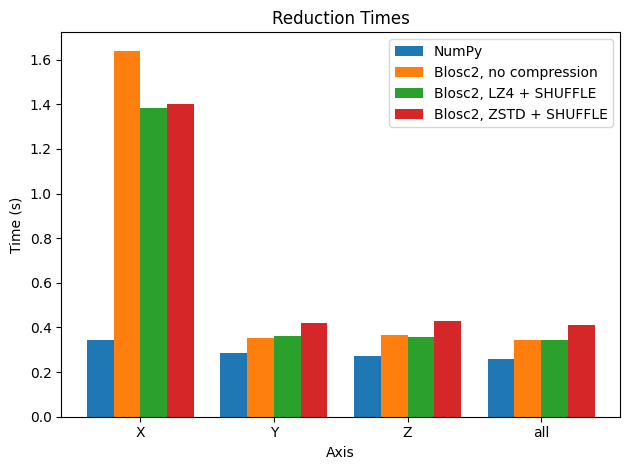

In [6]:
# Automatic chunking: (1, 1000, 1000) for i9 13900K
chunks = None
meas = measure_blosc2(chunks)
plot_meas(meas_np, meas, chunks)

There are a couple of things to comment on in the plot. The first is that Blosc2 achieves similar performance when using compression (most specially LZ4 + SHUFFLE) than when not using it, so in general (light) compression does not hurt performance too much. See later for a discussion on these results.

The second observation we can make is that, disappointingly, reductions along the X axis are much slower than those along the Y and Z axis for the Blosc2 case. This is because the automatically computed chunk shape is (1, 1000, 1000) making the overhead of partial sums larger for summing along the X axis. Why? If one sums along the Y axis for example, upon decompressing and summing a chunk of shape (1, 1000, 1000), one is left with a chunk of shape (1, 1000) that is already filled with the values of the final result. On the other hand, the same step, when summing along the X axis, results in a chunk of shape (1000, 1000) that then must be updated with the sum of the next chunk along the X axis, and so on and so on. This is explained in more detail below, but it should be clear that the performance difference is due to the chunk shape being different along the different axes.

Let's try to equalise the performance by manually setting the chunk size. In the next case, we want to make performance similar along the three axes, so we will set the chunk and block shapes more uniform.

chunks: (200, 200, 100), blocks: (1, 200, 100)
chunks: (200, 200, 100), blocks: (2, 200, 100)
cratio for LZ4 + SHUFFLE: 9.3x
chunks: (200, 200, 100), blocks: (1, 200, 100)
chunks: (200, 200, 100), blocks: (2, 200, 100)
cratio for ZSTD + SHUFFLE: 31.8x


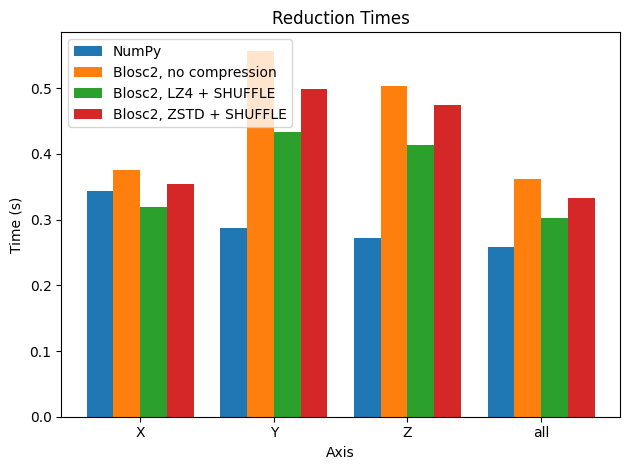

In [7]:
# Manual chunking
chunks = (200, 200, 100)
# blocks = (100, 50, 50)  # optional, but can help performance
meas = measure_blosc2(chunks, blocks=None)
plot_meas(meas_np, meas, chunks)

In this case, when using compression, performance for sums along the X axis is comparable than that for the Y and Z axes for Blosc2. Interestingly though, in other axes, performance is not better than using automatic chunking (which is recommended in most cases).

We could proceed further and try to fine tune the chunk and block size to get even better performance, but this is out of the scope of this tutorial. Instead, we will try to make some sense on the results above; see below.

## Performing reductions on 3D arrays

<div>
<img src="images/reductions/3D-cube-plane.png" width="300"/>
</div>

By default, Blosc2 chooses the chunk size so that it fits in the CPU cache (e.g. 8 MB); it then selects the chunk shape according to the NumPy convention of storing data row-wise, so that data that is contiguous within chunks is also contiguous in the full array. Hence, for the 3D case above (shown schematically in the figure), the default chunk shape, shown in pink, is (1, 1000, 1000). While chunking the data like this often speeds up computations and operations, in the case of reductions, it means that reduction times along different axes will not be the same, as the sizes are not uniform.

The difference in cost while traversing data values can be visualized more easily on a 2D array

<div>
<img src="images/reductions/memory-access-2D-x.png" width="500"/>
</div>

Reduction along the X axis: When accessing a chunk, the CPU can access the values from memory sequentially, but they need to be stored in an accumulator. The next chunk needs to be fetched from memory and each element added to the accumulator. If the size of the accumulator is large (in this case is `1000 * 1000 * 8 = 8 MB`), it does not fit in low level CPU caches, making this fetching, decompression and addition a slow procedure.

<div>
<img src="images/reductions/memory-access-2D-y.png" width="500"/>
</div>

Reducing along the Y axis: When accessing a chunk the CPU again accesses these values from memory sequentially but, contrarily to the case above, there is no need for an accumulator as the sum of the chunk along the Y axis already gives a row of the final result.  So, although the number of sum operations is the same as above, the required time is smaller because there is no need to update *all* the values of the accumulator per chunk, which reduces the time spent communicating between cache and processor.

### Tweaking the chunk shape

<div>
<img src="images/reductions/3D-cube.png" width="250"/>
</div>

However, when Blosc2 is instructed to create chunks that are the same shape for all the axes (`chunks=(200, 200, 100)`), the situation changes. In this case, an accumulator is needed for each subcube, but it is smaller (`200 * 100 * 8 = 160 KB`) and fits in L2, which is faster than L3 (scenario above). Since the chunk shape is nearly isomorphic, no axis is preferred and hence the performance is similar for all of them.

It is interesting to note that, when using compression, Blosc2 performance is similar to NumPy along *all* axes, except for the X axis, where performance is a bit better. This fact is even more interesting since the same underlying NumPy reduction machinery is used for each chunk by Blosc2 as well. This is a nice side effect of compression; see below.

### Effects of using different codecs in Python-Blosc2

Compression and decompression consume CPU and memory resources, however different codecs and configurations impact the use of these resources in different ways, and so it can be a good idea to alter the configuration to choose the most efficient option for the operating environment.

When compression is not applied, data is stored and accessed as-is, which saves the time spent on compression and decompression; however, especially if the data is large, the resulting higher memory usage can result in longer access times. Compression reduces the size of the data in memory and storage, which can improve performance when reading and writing data; but one then requires additional CPU time for compression and decompression. Therefore, it is important to find the right balance between reduced size and processing time to give overall optimal performance.

In the plots above, we can see how using the LZ4 codec is striking such a balance, as it achieves the best performance in general, exceeding the performance for uncompressed data. This is because LZ4 is tuned towards speed, and the time to compress and decompress the data is very low. On the other hand, ZSTD is a codec that is optimized for compression ratio, but is consequently a bit slower.  However, it is still faster than the uncompressed case, as the reduced memory transmission time compensates for the additional CPU time required for compression and decompression.

We have just scraped the surface for some of the compression parameters that can be tuned in Blosc2.  You can use the `CParams` object with the different parameters in [CParams reference](https://www.blosc.org/python-blosc2/reference/autofiles/storage/blosc2.CParams.html#blosc2.CParams) to set the compression level, codec, filters and other parameters.  We also offer automated parameter selection via the [Btune neural network tool](https://ironarray.io/btune) that, depending on your requirements for compression/decompression speed, compression ratio, or lossiness of compression, tries to select the best parameters for your application and CPU resources.

## Conclusion

Understanding the balance between minimising storage space and the additional time required to process the data is important. Testing different compression settings can help you obtain the best trade-off between reduced size and processing time. However, as a first approximation (without requiring the user to weigh up the particulars of their CPU cache structure), the default Blosc2 parameters are not too bad, since the chunk shape is automatically selected based on the CPU cache size. As we have seen, it is also easy to fine tune the chunk shape if necessary for our desired application.

Besides the ``sum`` reduction examined here, Blosc2 supports the main reduction operations (``mean``, ``std``, ``min``, ``max``, ``all``, ``any``, etc.), and you are invited to [explore them](../../reference/reduction_functions.html).

Although we didn't review it explicitly here, it is possible to use reductions even for very large arrays that are stored on disk, as is the case for the lazy expressions and functions we have seen in previous tutorials. This is immensely powerful for data analysis on large datasets, offering efficient computations on datasets that are compressed on-disk with minimal memory usage. We will explore this in a forthcoming tutorial.